# Structure Analysis of Musical Signals

In this lecture we will introduce the concepts of Audio Basis functions and Self-Similarity Analysis. These techniques are very common in computer audition, or trying to extract musical knowledge from sound recordings. 

In the previous class we discussed how to transform original data into a different "space" so that the structure or important aspects of the data would be retained. We also saw and example of using statistcs (histogram) as a feature. 

In the case the right feature is not known in advance, one powerful technique is to use the statistics of the data itself to find what is important and what is not. The basic tool in statistics to do so is called "correlation".
Correlation is very closely related to geometrical operaion of a dot product between vectors. In fact, many statistical methods that take into account co-variance between data variables (co-variance is the method to compute corrleation - see http://en.wikipedia.org/wiki/Covariance_and_correlation), can be considered as computing Euclidian distances in a space where the underlying distrubition is Gaussian or Normal distribution. 

We will not go into this important relation here, but many of the more complicated probabilities can be also mapped to geomertical spaces using so called Information Geometry, which is an mathematical important field pioneered by Shun'ichi Amari and other Japanese mathematicians in the 1980s, with many new applications emerging in various fields of engineering.

So let us now move on to the third method of feature extraction, which is data reduction or factorization technique that tries not only to find the best representation, but also keeps only the most salient "dimensions" or attributes of the data using statistical considerations. 


Let us take a look at our Audio example from last lecture.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

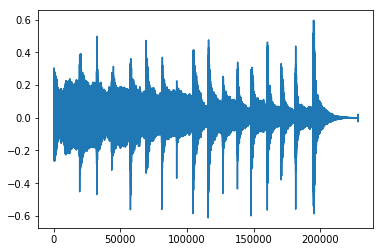

In [4]:
x, fs = librosa.load('./audio_files/ohm_scale.wav')
plt.plot(x)

Let's also reuse our program for Short Time Fourier Analysis (stft) and use it as our features.

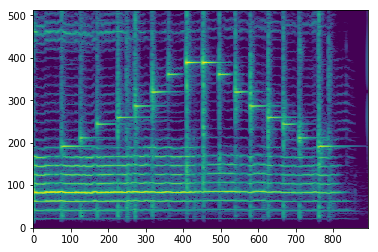

In [6]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=4096, hop_length=256)))[:512]
plt.imshow(X,origin='lower', aspect='auto')

This is an important example of why we would rather use the FFT amplitudes and not our original waveform data to computer similarity. As you will see below, we will use only partial information from the audio, which is the amplitudes of the frequency components, while ignoring the phase. This is quite intuitive that if we wanted to match to signals that sound to use the same, we would not care about the relative slight delay between the sounds, which is called "phase shift". This phase shift is what makes sinus wave different from a cosinus wave. But for the computer, matching sinus and cosine is very different and these are acually orthogonal elements if you think about them as vectors in the complex plane. So we can simply get rid of the mathematical inconvenience by using an amplitude representation of the different frequencies present in the signal, while ignoring their relative phase.

For various reasons, we would also prefer to use logartim of the spectrum (spectrum is the common name for amplitude of the Fourier components). Intuitively, this represents our logarithmic sensitiviey in perception of amplitude differences, but also mathematically this is a better fit to the notion of distance between spectra, also known formally as "log-spectral distance" http://en.wikipedia.org/wiki/Log-spectral_distance.

Also if we do not "care" about the overall loudness or energy but want to distinguish beween spectral shapes, or in other words consider two spectral similar even if their overall energy is different but the distribution or the pattern of which frequencies are present is similar, we might want to "normalize" each spectra by their total energy.

Our audio feature will be now the normalized log amplitudes of the first 512 FFT bins.


In [7]:
D = np.diag(1/np.sqrt(np.sum(X**2,0))) #
Xnorm = np.dot(X,D)
#imshow(Xnorm,origin='lower')

### *Comment For those more mathematically inclined*

*Recall that sum of logs of two varialbles is logs of their product, and difference of logs becomes log of a division. So if we want to compute an Euclidian distance*

$ \|x-y\|^2 = \|x\|^2 - 2xy + \|y\|^2 $
*and if*
$ x = log(a), y=log(b)$ *and* 
$ \|x \|^2 = \|y\|^2 = 1$,

*then we get after some algebra*

$log^2(a/b) = 2(1 - log(a)\cdot log(b)) = 2(1-x \cdot y)$,

*so our distance function between log spectra is actually is one minus the dot product between the individual log spectra. This is actually quite common, since a dot product of normalized vectors, also often called "cosine distance" is a measure of similarity, which is simply one minus the distance. Indeed, similarity is the opposite of distance ;)* 

### Computing Correlations

Now when we have our data processed to our satisfaction, we can start computing correlations betwen the rows or the colums of the data matrix.

Let us call **S** the product of rows, or along the time dimension, and **R** the product along columns, or the frequency dimension.

In [8]:
R = np.dot(Xnorm,Xnorm.T)
print R.shape

S = np.dot(Xnorm.T,Xnorm)
print S.shape

(512, 512)
(893, 893)


Both of these correlation matrices are important for extracting the essential information from our data. Matrix **S** captures similirities between the spectra across different time. This is easy to understand by visualizing it. Matrix **R** captures correlations across frequencies, and is harded visualize as such, although we will use its most important dimensions or principal vectors, to reduce the dimension of the data. 

Let's first visualize  matrix **S**, which is also known in computer music as "Self Similarity" matrix
http://en.wikipedia.org/wiki/Self-similarity_matrix

In [6]:

#plt.subplot(211)
#plt.imshow(Xnorm,origin='lower')

#plt.subplot(212)
#plt.imshow(S)

## What we have so far?

We used a relatively simple transform of our original data matrix to represent only those aspects of the data that we felt were essential. In practice we transformed our audio samples into Log-Spectrum using the FFT and taking logarithm of its amplitude. 

Next we asked a question about how the data are related. A simple way of comparing data is by so-called cosine distance. In this case we see that the Similarity matrix, computed as correlation or dot product of the raws (time dimension or simply index of the different instances or samples of our data) shows that there are many regions along our sound the similar sound exent occur. 

So the natural next step is to ask ourselves if we can exploit these similarities and somehow represent the data in a more compact way by extracting templates, or some typical spectral shapes, that capture most of the audio structure. Fortunately, there is a simple way to do that using Singular Value Decomposition (SVD).


In [7]:
#np.linalg.svd?

Let see what happens if we apply SVD to our data matrix. This would allow us to reveal more features by retaining only the essential elements. 
Reminder: the inner workings of SVD were explained in the data-factorization lecture.

In [9]:
U, D, V = np.linalg.svd(Xnorm)

U = np.matrix(U)
V = np.matrix(V)
Xnorm = np.matrix(Xnorm)

## Audio Basis and Karhunen-Loeve Transform

The decomoposition of our data matrix **X** into three matrices **X** = **UDV** can be also seen as a combination of two matrices: **U** that provides coordinates for a new space where frequency elements are combined differently and in more efficient way that allows also a lower-dimensional representation, and a set of coefficients **C** = **DV** that give the relative weights of each basis element over time.

Accordngly, **U** are sometimes called Audio Basis Vecotors, and the combination of **V** with their relative "strengths" **D** are called "time coefficients" or "expension coefficients". 

By changing the number of dimensions we can see different aspects of the similarity in the data. The "trick" is to combine only the first few columns of the matrix **U** with few of the corresponding rows of **V**.

## Karhunen-Loeve Transform

Karhunen-Loeve Trasform or KLT for short, is an important transformation technique in Digital Signal Processing and signal compression in particular, that is used to change the representation a stream of digital data, such as sequence of FFT above, into a more efficient representation. This method is closely related to the PCA technique we discussed in the lecture on Data Factorization, and basically it has the same mathematical theory. 

One simple way to understand KLT is by noting that in the SVD representation, the basis vectors **U** are orthonormal, so by multiplication of our data matrix by the transposed of **U**, we will immediately obtain the coefficients **C=DV**. Since we need only few coefficients to capture the essential structure of the data, we need only transmit few of them and thus obtain data reduction or compression.
Then in the reconstruction step all we need is to multiply the coefficients back by the basis **U** to recover the original data.

Of course this is a "lossy" method, since we intentionally throw away some of the coefficient streams to achieve compression. So our reconstruction will be also in a sub-space, or in other words it will be using only few of the dominant basis function to recover the original contents.

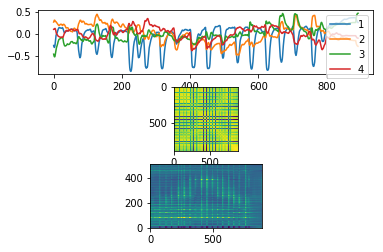

In [10]:
dim = 5

#Xdim = U[:,:dim]*diag(D[:dim])*V[:dim,:]
KLT = U[:,:dim].T * Xnorm
Xdim = U[:,:dim] * KLT

plt.subplot(311)
for i in range(1,dim):
    plt.plot(np.array(KLT[i,:]).T, label=str(i))
plt.legend()

plt.subplot(312)
plt.imshow(KLT.T*KLT)

plt.subplot(313)
plt.imshow(Xdim,origin='lower')

#This is the same as doing+
#subplot(211)
#imshow(Xdim,origin='lower')
#subplot(212)
#imshow(Xdim.T*Xdim)


The number of classes might be also inferred from these time-coefficient, which are, as you might recall, the eigenvectors of the Similarity Matrix. For those interested in looking deeper into the subject, a very powerful technique that is closely related to SVD-based structure analysis is so called Spectral Clustering. It can be shown that with some extra normalization step that translates the self-similarity into a probability matrix, the first few eignevectors (exculding the first one, for some mathematical reason), can be used to cluster the audio vectors into classes or groups of related objects, and thus achieve even better reduction or deeper extraction of knowledge from the signal. For more details see my paper on Audio Segmentation by Singular Value Clustering

http://www.academia.edu/3413075/Audio_Segmentation_by_Singular_Value_Clustering